In [1]:
# import
import warnings
import os
import sys
import cv2
import pickle
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from glob import glob
from pprint import pprint
from sklearn.cluster import KMeans, MiniBatchKMeans
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler


class Samples_container:
    imgs_real_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/part/*.jpg")
    imgs_color_black = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/black/*.jpg")
    imgs_color_white = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/white/*.jpg")
    imgs_color_green = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/green/*.jpg")
    imgs_color_red = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/red/*.jpg")
    imgs_entire = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/entire/*.jpg")
    imgs_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/picture/*.png")
    videos_num = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/number/*.mp4")
    videos = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/*.mp4")


In [2]:
# initial settings

print("OpenCV", cv2.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("Pyautogui", pg.__version__)
print("Scikit-learn", sklearn.__version__)

warnings.simplefilter('ignore')  # すべての警告を非表示にする


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


samples = Samples_container()


OpenCV 4.5.4
numpy 1.20.1
pandas 1.2.4
Pyautogui 0.9.53
Scikit-learn 0.24.1


In [3]:
# カラーパレットを用意する
from matplotlib.colors import ListedColormap
colors = ["white", "black", "green", "red"]
cmap = ListedColormap(colors, name="custom")

col_model = LoadInstances("./ColorReco2.pickle")


(array([1, 2], dtype=int64),)
[[0. 0.]]
{'black_amount_bottom': 190,
 'black_amount_upper': 281,
 '緑': 0.04,
 '赤': 0.0,
 '黒出現中心(上)': -2.0,
 '黒出現中心(下)': -1.0}
{'交差点 Uターン': False,
 '交差点 右折': False,
 '交差点 左折': True}


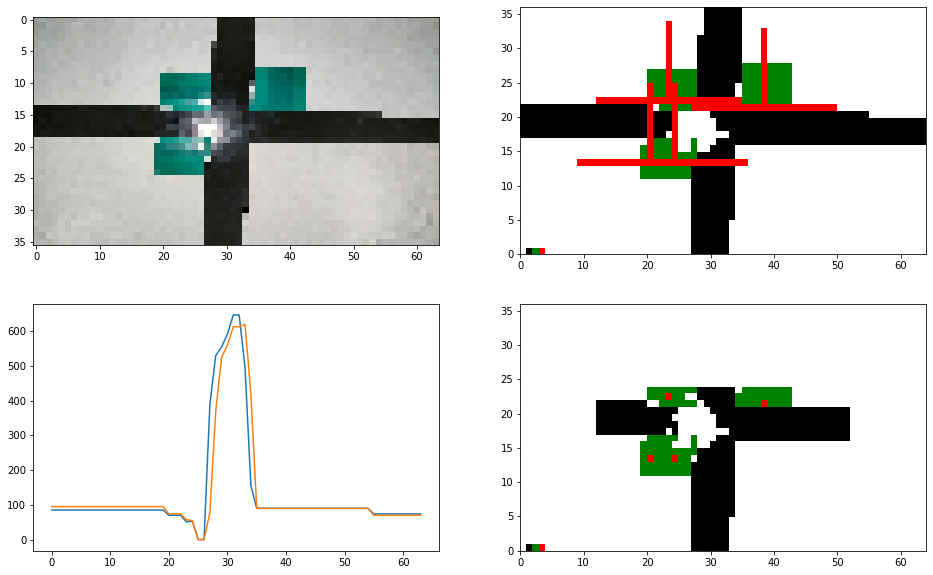

(array([0, 1], dtype=int64),)
[[1. 9.]]
{'black_amount_bottom': 141,
 'black_amount_upper': 478,
 '緑': 0.05,
 '赤': 0.0,
 '黒出現中心(上)': 0.0,
 '黒出現中心(下)': -2.0}
{'交差点 Uターン': False,
 '交差点 右折': True,
 '交差点 左折': False}


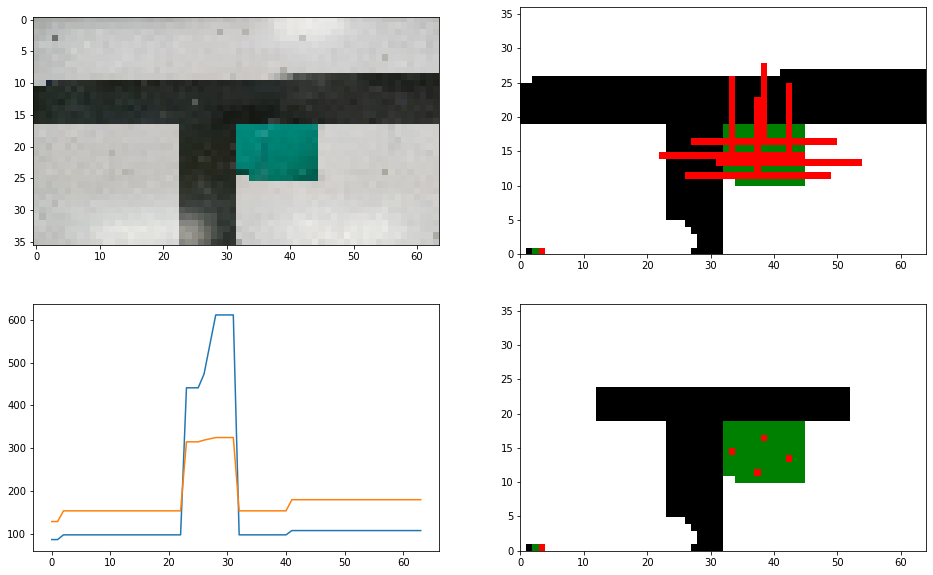

{'black_amount_bottom': 98,
 'black_amount_upper': 111,
 '緑': 0.0,
 '赤': 0.14,
 '黒出現中心(上)': -8.0,
 '黒出現中心(下)': -9.0}


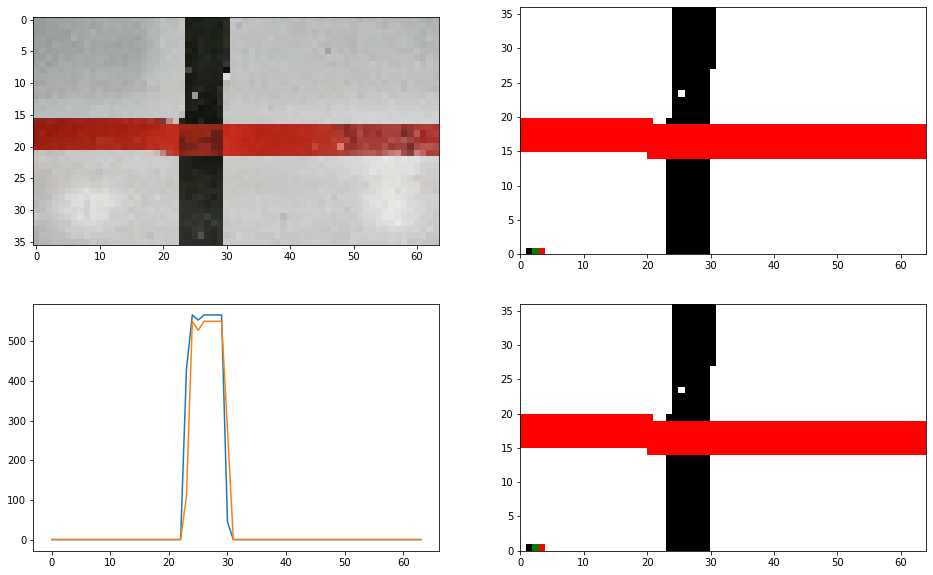

(array([0, 1], dtype=int64),)
[[5. 6.]]
{'black_amount_bottom': 182,
 'black_amount_upper': 218,
 '緑': 0.02,
 '赤': 0.0,
 '黒出現中心(上)': 2.0,
 '黒出現中心(下)': -12.0}
{'交差点 Uターン': False,
 '交差点 右折': True,
 '交差点 左折': False}


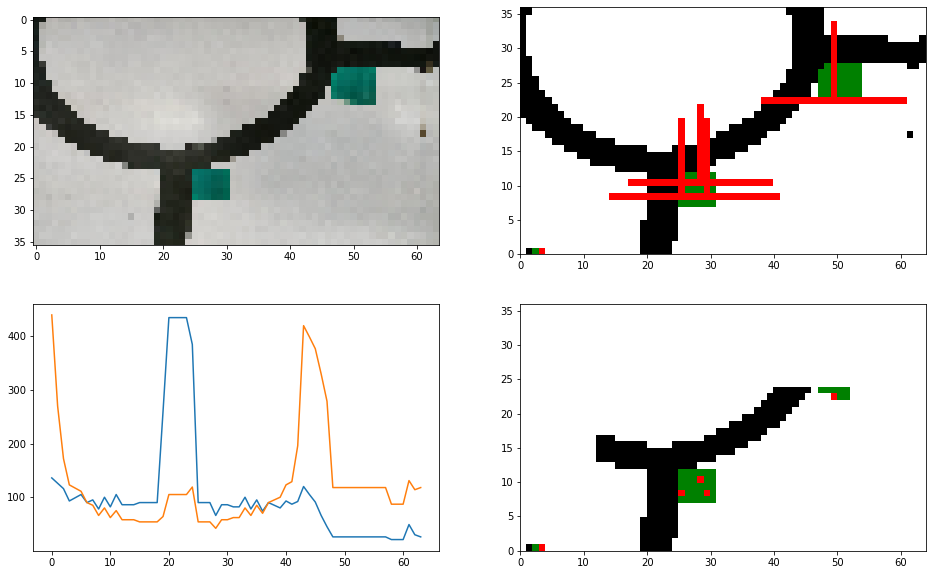

(array([0], dtype=int64),)
[[8.]]
{'black_amount_bottom': 215,
 'black_amount_upper': 295,
 '緑': 0.04,
 '赤': 0.0,
 '黒出現中心(上)': 3.0,
 '黒出現中心(下)': 3.0}
{'交差点 Uターン': False,
 '交差点 右折': True,
 '交差点 左折': False}


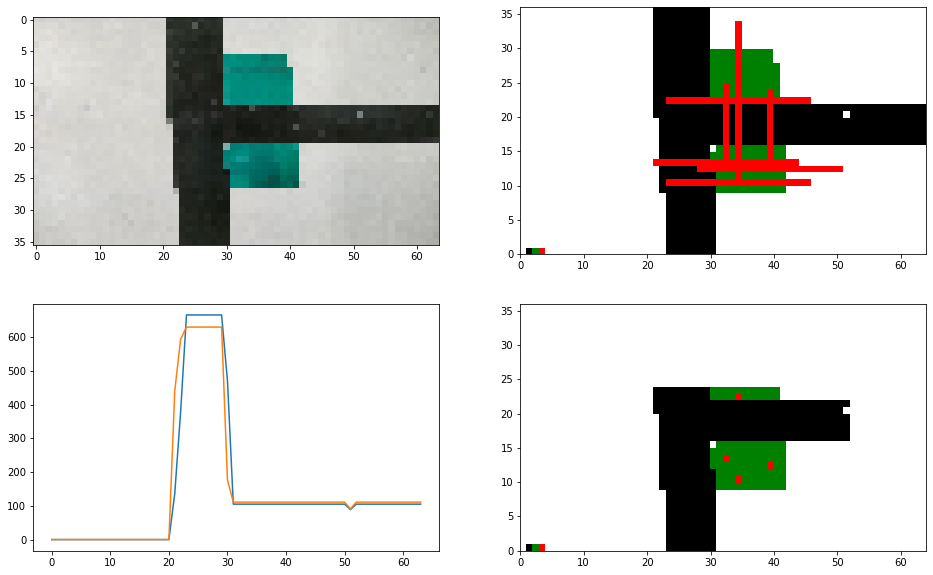

(array([0, 1], dtype=int64),)
[[0. 5.]]
{'black_amount_bottom': 424,
 'black_amount_upper': 266,
 '緑': 0.12,
 '赤': 0.0,
 '黒出現中心(上)': 1.0,
 '黒出現中心(下)': 0.0}
{'交差点 Uターン': True,
 '交差点 右折': True,
 '交差点 左折': True}


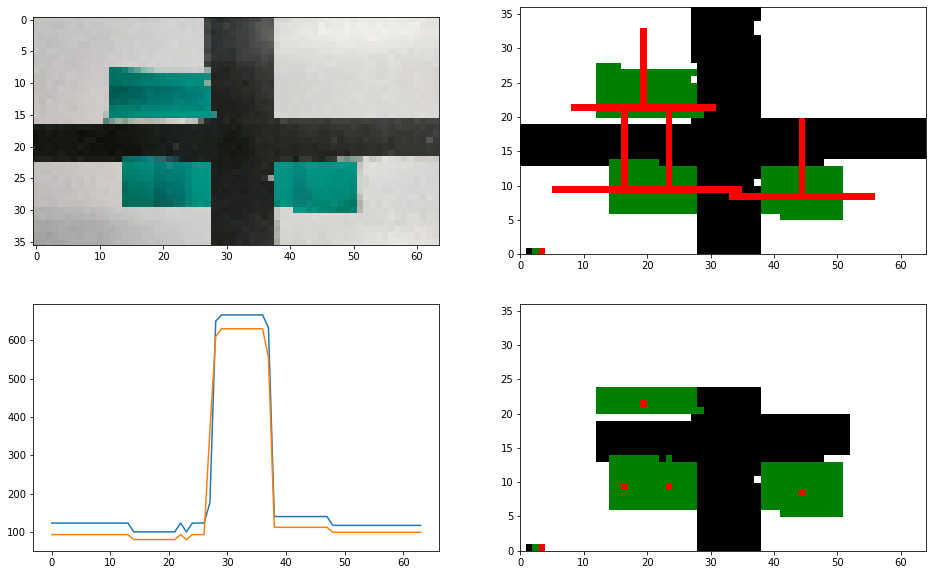

(array([0, 1], dtype=int64),)
[[6. 7.]]
{'black_amount_bottom': 204,
 'black_amount_upper': 200,
 '緑': 0.03,
 '赤': 0.0,
 '黒出現中心(上)': 11.0,
 '黒出現中心(下)': -10.0}
{'交差点 Uターン': False,
 '交差点 右折': True,
 '交差点 左折': False}


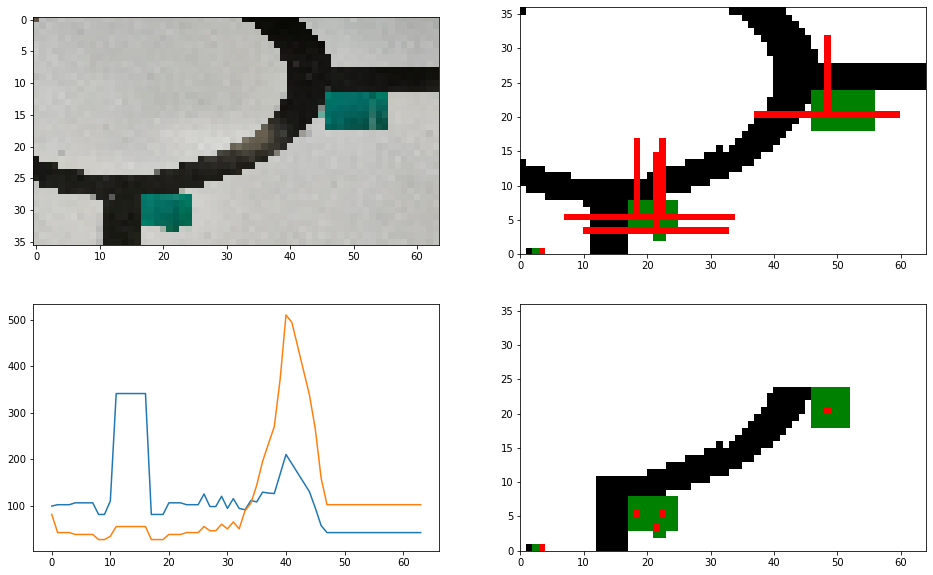

(array([1, 2], dtype=int64),)
[[0. 0.]]
{'black_amount_bottom': 213,
 'black_amount_upper': 227,
 '緑': 0.03,
 '赤': 0.0,
 '黒出現中心(上)': 4.0,
 '黒出現中心(下)': 10.0}
{'交差点 Uターン': False,
 '交差点 右折': False,
 '交差点 左折': True}


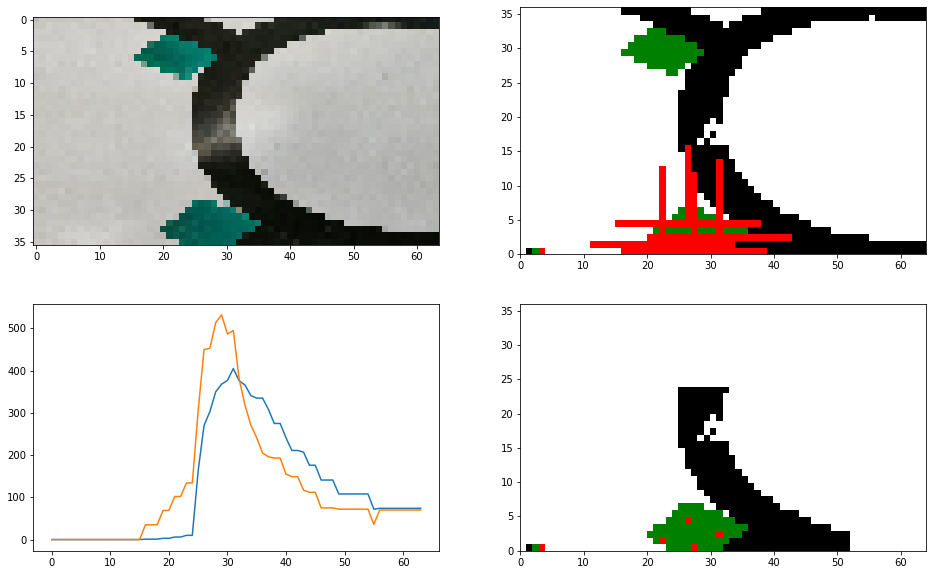

(array([1, 2], dtype=int64),)
[[0. 0.]]
{'black_amount_bottom': 167,
 'black_amount_upper': 268,
 '緑': 0.03,
 '赤': 0.0,
 '黒出現中心(上)': 5.0,
 '黒出現中心(下)': 1.0}
{'交差点 Uターン': False,
 '交差点 右折': False,
 '交差点 左折': True}


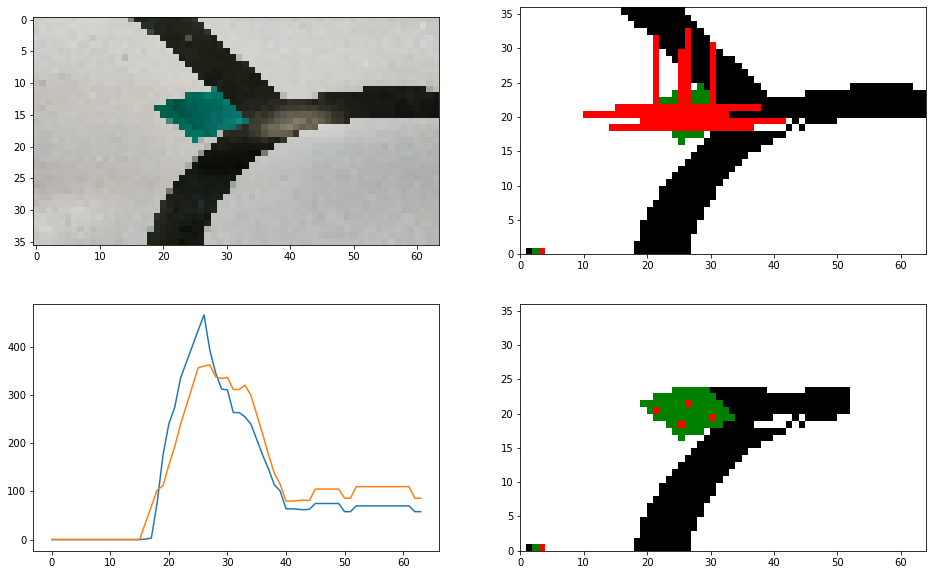

{'black_amount_bottom': 255,
 'black_amount_upper': 236,
 '緑': 0.0,
 '赤': 0.0,
 '黒出現中心(上)': -3.0,
 '黒出現中心(下)': -7.000000000000001}


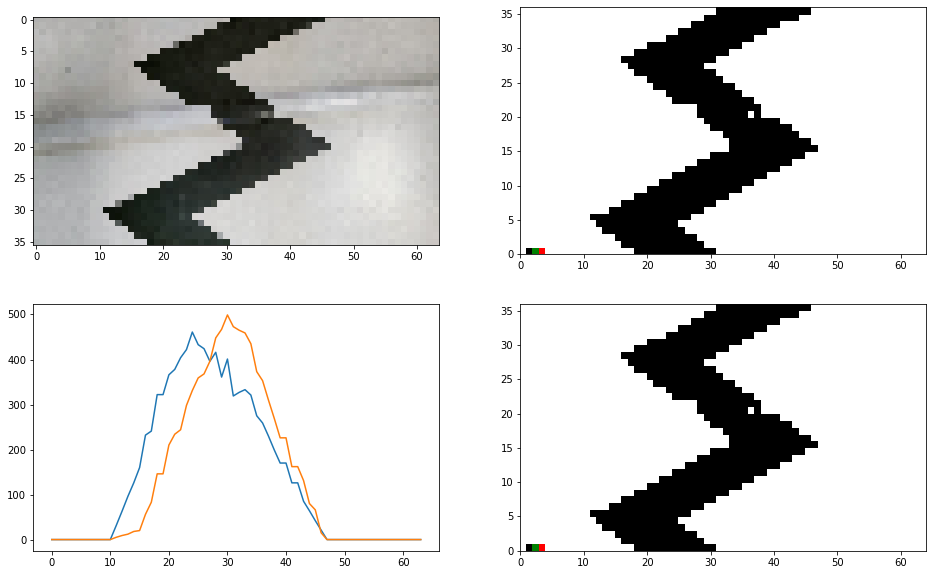

{'black_amount_bottom': 40,
 'black_amount_upper': 90,
 '緑': 0.0,
 '赤': 0.0,
 '黒出現中心(上)': 3.0,
 '黒出現中心(下)': 4.0}


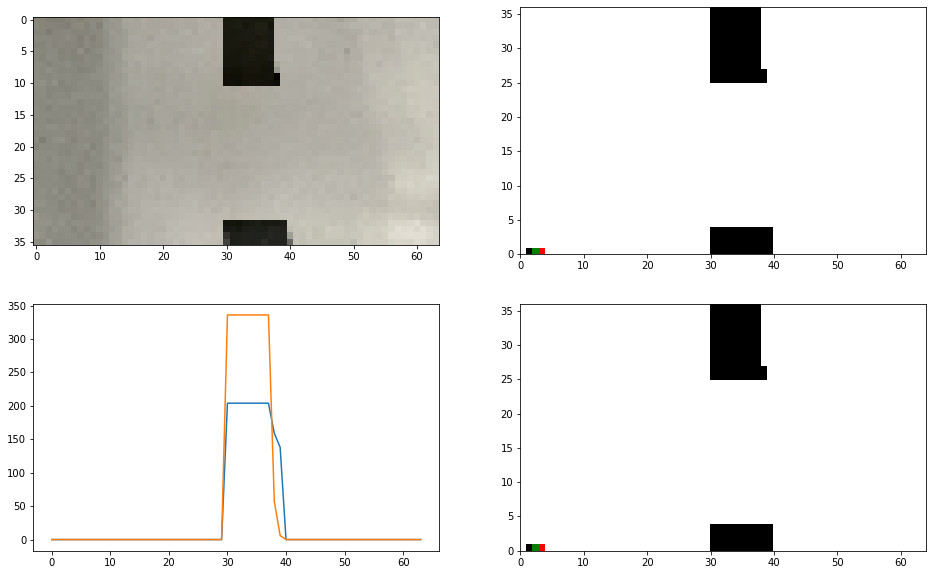

{'black_amount_bottom': 212,
 'black_amount_upper': 236,
 '緑': 0.0,
 '赤': 0.0,
 '黒出現中心(上)': 15.0,
 '黒出現中心(下)': 1.0}


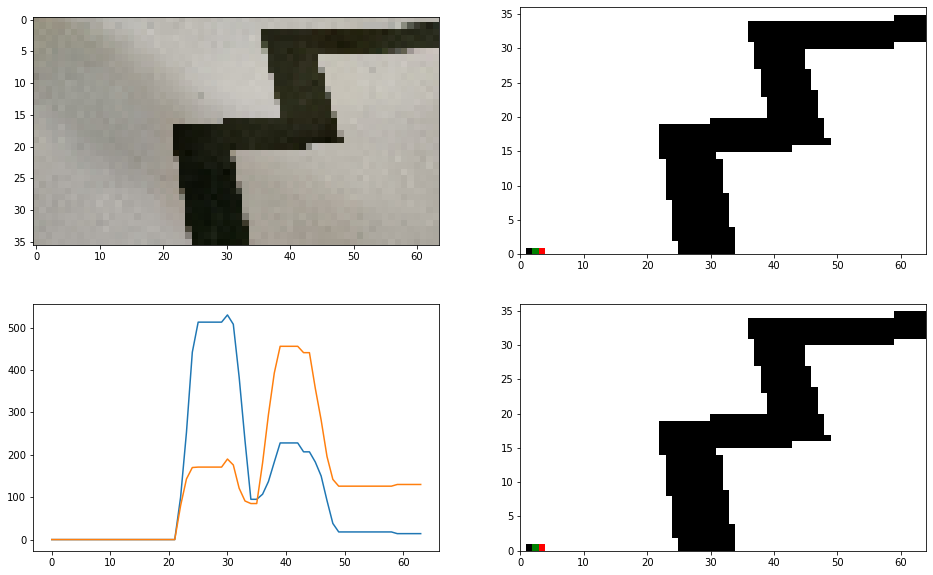

{'black_amount_bottom': 257,
 'black_amount_upper': 232,
 '緑': 0.0,
 '赤': 0.0,
 '黒出現中心(上)': 13.0,
 '黒出現中心(下)': -1.0}


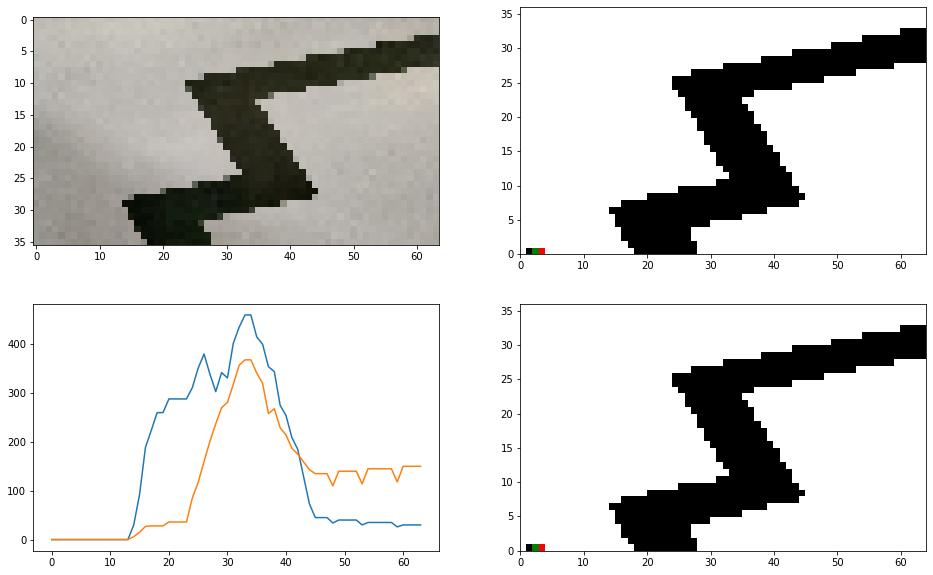

{'black_amount_bottom': 244,
 'black_amount_upper': 33,
 '緑': 0.0,
 '赤': 0.0,
 '黒出現中心(上)': -8.0,
 '黒出現中心(下)': -14.000000000000002}


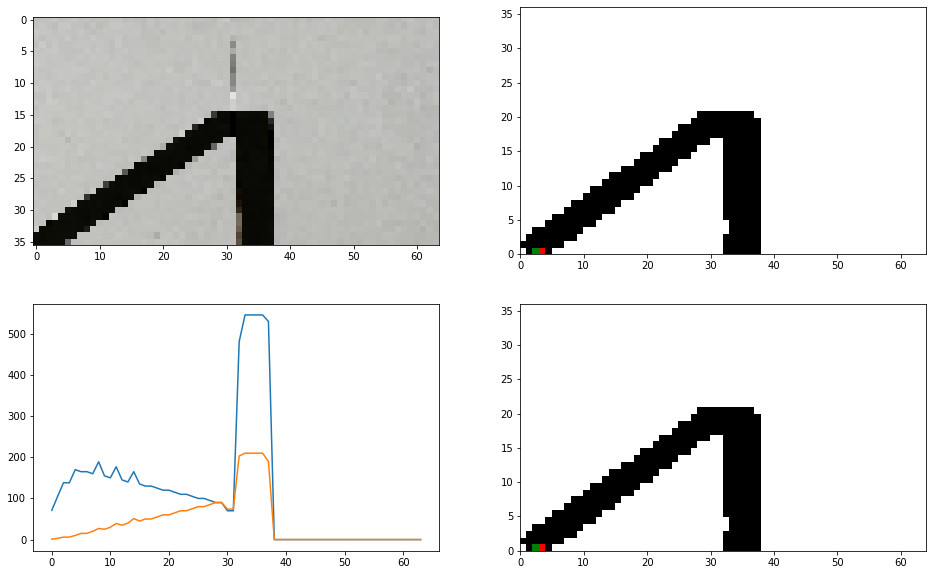

(array([1, 2], dtype=int64),)
[[0. 6.]]
{'black_amount_bottom': 315,
 'black_amount_upper': 371,
 '緑': 0.12,
 '赤': 0.0,
 '黒出現中心(上)': 1.0,
 '黒出現中心(下)': 1.0}
{'交差点 Uターン': True,
 '交差点 右折': True,
 '交差点 左折': True}


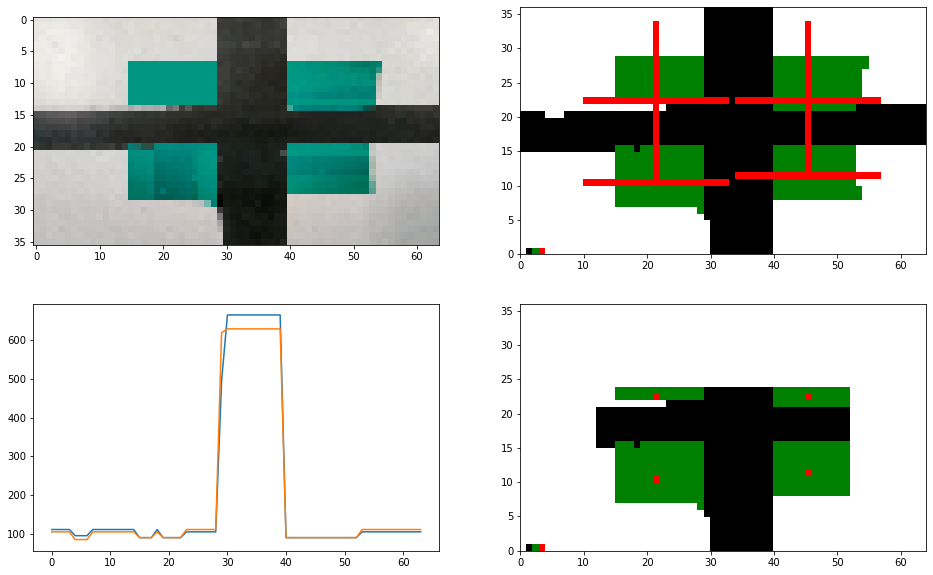

Timer unit: 1e-07 s

Total time: 11.0215 s
File: C:\Users\Haya\AppData\Local\Temp/ipykernel_5336/1856205440.py
Function: main at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def main():
     8        16        443.0     27.7      0.0      for path in samples.imgs_real_part:
     9                                                   # 写真を読み込む
    10        15   20149763.0 1343317.5     18.3          frame = cv2.imread(path)
    11                                                   #
    12        15     392685.0  26179.0      0.4          frame = cv2.resize(frame, (64, 36))
    13        15        836.0     55.7      0.0          height, width = frame.shape[:2]
    14                                                   #
    15                                                   # 色を識別する
    16        30       1568.0     52.3      0.0          recognized_frame = np.flipud(
    17        30       1303.0     43.4      0.0

In [4]:
# 本体

OFFSET_CHECK_EXIST_BLACK = 12
BLACK_COUNT = 3


def main():
    for path in samples.imgs_real_part:
        # 写真を読み込む
        frame = cv2.imread(path)
        #
        frame = cv2.resize(frame, (64, 36))
        height, width = frame.shape[:2]
        #
        # 色を識別する
        recognized_frame = np.flipud(
            np.reshape(
                col_model.predict(np.reshape(frame, (-1, 3))),
                np.shape(frame)[:2]
            )
        )
        #
        # 画面上部と画面下部における黒の総量
        temp_frame_height_middle = math.floor(len(recognized_frame) / 2)
        black_amount_bottom = np.sum(np.where(recognized_frame[:temp_frame_height_middle, :] == 1, 1, 0))
        black_amount_upper = np.sum(np.where(recognized_frame[temp_frame_height_middle:, :] == 1, 1, 0))
        #
        # 画像縦列における黒の出現割合
        black_distribution_weighted_bottom = np.sum(np.array(np.where(recognized_frame == 1, 1, 0)) *
                                                    np.reshape(np.arange(len(recognized_frame), 0, -1), (-1, 1)), axis=0)
        black_distribution_weighted_upper = np.sum(np.array(np.where(recognized_frame == 1, 1, 0)) *
                                                   np.reshape(np.arange(0, len(recognized_frame), 1), (-1, 1)), axis=0)
        #
        # 画像縦列における黒の出現位置の中心インデックス
        black_center_position_weighted_bottom = np.round((np.sum(black_distribution_weighted_bottom * np.arange(
            0, len(black_distribution_weighted_bottom), 1))) / np.sum(black_distribution_weighted_bottom) / width - 0.5, 2) * 100
        black_center_position_weighted_upper = np.round((np.sum(black_distribution_weighted_upper * np.arange(0,
                                                        len(black_distribution_weighted_upper), 1))) / np.sum(black_distribution_weighted_upper) / width - 0.5, 2) * 100
        #
        # 画像全体における赤の出現インデックスを抽出
        raw_red_appeared = np.where(recognized_frame == 3)
        red_appeared = np.hstack((np.reshape(raw_red_appeared[0], (-1, 1)), np.reshape(raw_red_appeared[1], (-1, 1))))  # ["height", "width"]
        occupy_red_appeared = np.round(len(red_appeared) / (height * width), 2)
        #
        # 画像全体における緑の出現インデックスを抽出
        is_green_found = len(np.where(recognized_frame == 2)[0]) != 0
        if is_green_found:
            # 緑の周囲に黒が存在するかを確認するための配列を作る
            temp_recognized_frame = np.zeros_like(recognized_frame)
            temp_enabled_zone = np.s_[:OFFSET_CHECK_EXIST_BLACK * -1, OFFSET_CHECK_EXIST_BLACK:OFFSET_CHECK_EXIST_BLACK * -1]
            temp_recognized_frame[temp_enabled_zone] = recognized_frame[temp_enabled_zone]
        #
            # 緑色であるピクセルの位置インデックス
            temp_green_appeared = np.where(temp_recognized_frame == 2)
            green_appeared = (
                np.hstack((np.reshape(temp_green_appeared[0], (-1, 1)), np.reshape(temp_green_appeared[1], (-1, 1)))))  # ["height", "width"]
        #
            # 緑色のピクセルインデックスを４つに絞り込む
            green_KMeans_center = np.array(MiniBatchKMeans(n_clusters=4).fit(green_appeared).cluster_centers_).astype(np.int16)
        #
            # 全体に占める緑色の割合
            occupy_green_appeared = np.round(len(green_appeared) / (height * width), 2)
        #
            green_cluster_around = np.zeros((1, 3))
            for i in range(len(green_KMeans_center)):
                x = green_KMeans_center[i, 0]
                y = green_KMeans_center[i, 1]
                of = OFFSET_CHECK_EXIST_BLACK
                ones = np.ones(OFFSET_CHECK_EXIST_BLACK).astype(np.int16)
                upper = np.sum(np.where(recognized_frame == 1, 1, 0)[np.arange(x, x + of, 1), ones * y])
                right = np.sum(np.where(recognized_frame == 1, 1, 0)[ones * x, np.arange(y, y + of, 1)])
                left = np.sum(np.where(recognized_frame == 1, 1, 0)[ones * x, np.arange(y, y - of, -1)])
                green_cluster_around = np.append(green_cluster_around, [[left, upper, right]], axis=0)
                # @for anchor
            green_cluster_around = np.round(green_cluster_around[1:, :], 2)
            temp = np.where(green_cluster_around[1] >= BLACK_COUNT)
            print(temp)
            is_this_meant_right = True in (green_cluster_around[temp, 0] >= BLACK_COUNT)
            print(green_cluster_around[temp, 0])
            is_this_meant_left = True in (green_cluster_around[temp, 2] >= BLACK_COUNT)
            is_this_meant_turn = is_this_meant_right and is_this_meant_left   # is_this_meant_left and is_this_meant_right
        else:
            # タイルに緑色がない
            occupy_green_appeared = 0.0
        #
        # メッシュ図の表示用に調整する
        for array in [recognized_frame, temp_recognized_frame]:
            array[0][0] = 0  # meant white
            array[0][1] = 1  # meant black
            array[0][2] = 2  # meant green
            array[0][3] = 3  # meant red
        #
        # 表示
        features = {
            "black_amount_bottom": black_amount_bottom,
            "black_amount_upper": black_amount_upper,
            "黒出現中心(下)": black_center_position_weighted_bottom,
            "黒出現中心(上)": black_center_position_weighted_upper,
            "緑": occupy_green_appeared,
            "赤": occupy_red_appeared,
        }
        pprint(features, width=1)
        recognized_frame_for_display = np.copy(temp_recognized_frame)
        if is_green_found:
            pprint({
                "交差点 右折": is_this_meant_right,
                "交差点 左折": is_this_meant_left,
                "交差点 Uターン": is_this_meant_turn, }, width=1)
            # pprint(green_cluster_around, width=1)
            # pprint(green_KMeans_center, width=1)
            recognized_frame_for_display[green_KMeans_center[:, 0], green_KMeans_center[:, 1]] = 3
            for i in range(len(green_KMeans_center)):
                x = green_KMeans_center[i, 0]
                y = green_KMeans_center[i, 1]
                of = OFFSET_CHECK_EXIST_BLACK
                recognized_frame[x, y] = 3
                recognized_frame[np.arange(x, x + of, 1), y] = 3
                recognized_frame[x, np.arange(y, y + of, 1)] = 3
                recognized_frame[x, np.arange(y, y - of, -1)] = 3
        else:
            recognized_frame_for_display = np.copy(recognized_frame)
        plt.figure(figsize=(16, 10))
        plt.subplot(221)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # -> 注意
        plt.subplot(222)
        plt.pcolormesh(recognized_frame, cmap=cmap)
        plt.subplot(223)
        plt.plot(black_distribution_weighted_bottom)
        plt.plot(black_distribution_weighted_upper)
        plt.subplot(224)
        plt.pcolormesh(recognized_frame_for_display, cmap=cmap)
        plt.show()


pl = LineProfiler()
pl.add_function(main)
pl.runcall(main)
pl.print_stats()


In [5]:
np.arange(1, 10, 1)


array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
np.arange(1, 10, 1) > 5


array([False, False, False, False, False,  True,  True,  True,  True])

In [4]:
#python送信側

import socket
import random
import time

HOST = '127.0.0.1'
PORT = 50007

client = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
while True:
    a = random.randrange(5) - 2
    result = str(a)
    print(a)
    client.sendto(result.encode('utf-8'), (HOST, PORT))
    time.sleep(1/8)


-1
-1
2
-2
-1
-2
-1
-1
0
2
2
-1
-2
-1
-2
-2
1
0
-2
0
1
-2
-1
-2
0
1
-1
0
0
2
2
2
2
1
0
1
-2
-2
2
-2
-2
0
2
-1
1
-2
-2
-2
-1
2
1
-1
1
1
0
-2
-1
-1
-1
0
-2
2
-1
1
0
1
1
1
1
1
0
-1
-1
-1
-1
-1
-1
0
0
-2
0
-1
1
-1
-2
1
-1
0
0
-1
2
1
1
1
-1
0
2
1
-2
1
2
0
1
-2
0
1
-2
2
0
-1
1
-1
-2
1
-2
2
-1
-1
2
2
-1
1
-2
1
-1
0
1
1
1
2
0
-2
-2
-1
-2
-2
2
-2
0
2
2
-2
-1
0
0
0
-2
0
-1
2
1
-1
0
0
1
1
-2
1
1
2
1
0
0
1
-1
2
-1
1
0
-1
1
-2
-2
-1
2
2
2
2
1
1
-1
1
-2
-2
-2
0
1
-2
1
0
2
1
-1
-2
0
-1
-1
0
0
-1
-2
1
0
1
0
-1
2
1
-1
0
-1
0
0
-1
2
0
1
1
-1
-1
-1
2
2
-2
0
-1
-1
2
0
2
1
0
2
2
0
0
0
-1
2
-2
-2
-2
2
1
-2
0
-1
-1
-1
1
1
1
2
-2
-2
-2
2
0
1
2
-2
-2
1
2
0
-2
1
-2
0
1
-2
0
-1
0
-1
2
0
0
-2
1
1
1
-2
2
-2
-1
0
1
1
0
0
2
-2
1
1
1
0
2
-2
2
-2
0
1
2
2
-2
-2
2
-2
2
1
1
0
0
-1
0
-1
-2
-1
2
0
1
2
2
1
1
2
-2
0
1
0
0
-2
2
0
-1
-1
-2
-1
2
-2
1
0
1
2
-2
2
2
-1
-2
-1
0
0
-1
0
-1
2
-1
1
-1
-2
2
1
-2
0
1
-1
0
0
-1
2
2


KeyboardInterrupt: 